In [4]:
import torch

from utils.parsing import parse_args
from model.frame_docking.frame_docking_flow import FrameDockingVerletFlow

args = parse_args(manual_args = [])
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [5]:
# Load best model for inference

weights_path = 'workdir/best_model.pt'

flow = FrameDockingVerletFlow(
    num_coupling_layers = args.num_coupling_layers,
    distance_embed_dim = args.distance_embed_dim,
    device = device,
)
flow.load_state_dict(torch.load(weights_path))
flow = flow.to(device)
flow.eval()


FrameDockingVerletFlow(
  (coupling_layers): ModuleList(
    (0): FrameDockingCouplingLayer(
      (st_net): FrameDockingScoreModel(
        (_offset_distance_embedding): GaussianSmearing()
        (_tp1): FullyConnectedTensorProduct(6x0e+1x1e x 6x0e+1x1e -> 20x0e+5x1e | 805 paths | 805 weights)
        (_tp2): FullyConnectedTensorProduct(20x0e+5x1e x 6x0e+1x1e -> 9x0e+1x1e | 1180 paths | 1180 weights)
      )
    )
    (1): FrameDockingCouplingLayer(
      (st_net): FrameDockingScoreModel(
        (_offset_distance_embedding): GaussianSmearing()
        (_tp1): FullyConnectedTensorProduct(6x0e+1x1e x 6x0e+1x1e -> 20x0e+5x1e | 805 paths | 805 weights)
        (_tp2): FullyConnectedTensorProduct(20x0e+5x1e x 6x0e+1x1e -> 9x0e+1x1e | 1180 paths | 1180 weights)
      )
    )
    (2): FrameDockingCouplingLayer(
      (st_net): FrameDockingScoreModel(
        (_offset_distance_embedding): GaussianSmearing()
        (_tp1): FullyConnectedTensorProduct(6x0e+1x1e x 6x0e+1x1e -> 20x0e+5x1e | 80

## Data to Latent

In [6]:
from datasets.frame_dataset import FrameDataset, VerletFrame
from torch.utils.data import DataLoader

num_test_items = 1
batch_size = 1

# Construct dataset
test_dataset = FrameDataset(
    num_items = num_test_items,
    device = device
)

# Construct loader
test_loader = DataLoader(
    dataset = test_dataset,
    batch_size = batch_size
)

In [11]:
test_batch = VerletFrame(*next(iter(test_loader)))

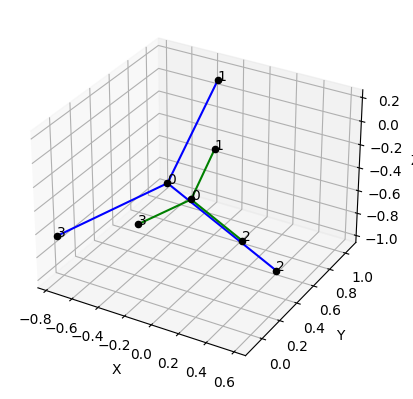

In [53]:
# Graph in-distribution frame
from utils.visualization import graph_frame

data_batch = test_batch.tensor_op('clone')
graph_frame(data_batch.receptor.squeeze().cpu(), data_batch.ligand.squeeze().cpu())

In [55]:
# Compute latent
# log_pxv = latent density
# delat_log_pxv = acquired density through deformations
latent_batch, log_pxv, delta_log_pxv = flow.data_to_latent(test_batch)
print(f'log_pxv: {log_pxv}, delta_log_pxv: {delta_log_pxv}')

log_pxv: tensor([[-337.2036]], device='cuda:0', grad_fn=<AddBackward0>), delta_log_pxv: tensor([13.0059], device='cuda:0')


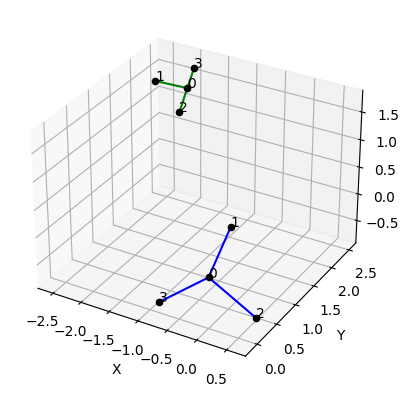

In [56]:
graph_frame(latent_batch.receptor.squeeze().detach().cpu(), latent_batch.ligand.squeeze().detach().cpu())

## Utility

In [21]:
import importlib, sys

In [22]:
importlib.reload(sys.modules['datasets.frame_dataset'])

<module 'datasets.frame_dataset' from '/data/scratch/erives/verlet_flows/datasets/frame_dataset.py'>